In [1]:
!pip install tensorflow numpy opencv-python matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [7]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [9]:
import os, cv2, uuid
import tensorflow as tf

def data_aug(img):
    data = []
    for i in range(9):
        aug_img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(i,1))
        aug_img = tf.image.stateless_random_contrast(aug_img, lower=0.6, upper=1, seed=(i,2))
        data.append(aug_img)
    return data

In [10]:
# Load image
img_path = os.path.join(ANC_PATH, '2b92ddd7-7e88-11f0-b053-34e6ad90073f.jpg')
img = cv2.imread(img_path)

if img is None:
    raise ValueError(f"Could not load image at {img_path}")

# Convert BGR → RGB → Tensor
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.convert_to_tensor(img, dtype=tf.float32)

# Apply augmentation
augmented_images = data_aug(img)

# Save augmented images
for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())),
                cv2.cvtColor(image.numpy().astype("uint8"), cv2.COLOR_RGB2BGR))

In [11]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
print(dir_test.next())

b'data\\anchor\\9cff6365-7f1b-11f0-909c-34e6ad90073f.jpg'


In [14]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img


In [15]:
img = preprocess('data\\anchor\\2b92ddd7-7e88-11f0-b053-34e6ad90073f.jpg')

In [16]:
img.numpy().max() 

0.8617647

In [ ]:
dataset.map(preprocess)

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
samples = data.as_numpy_iterator()

In [19]:
example = samples.next()

In [20]:
example

(b'data\\anchor\\386df1e9-7e88-11f0-987b-34e6ad90073f.jpg',
 b'data\\positive\\4f2bbd5e-7e88-11f0-94e3-34e6ad90073f.jpg',
 1.0)

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
res = preprocess_twin(*example)

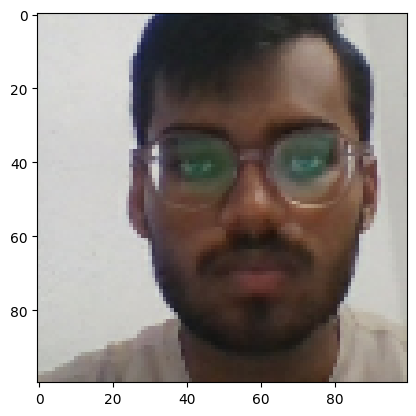

In [23]:
plt.imshow(res[1])

In [24]:
res[2]

1.0

In [25]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [26]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [27]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [28]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [29]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [30]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                     ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)         │ (None, 100, 100, 3)      │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d (Conv2D)                  │ (None, 91, 91, 64)       │        19,264 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)     │ (None, 46, 46, 64)       │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)                │ (None, 40, 40, 128)      │       401,536 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)   │ (None, 20, 20, 128)      │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)                │ (None, 17, 17, 128)      │       262,272 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)   │ (None, 9, 9, 128)        │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)                │ (None, 6, 6, 256)        │       524,544 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ flatten (Flatten)                │ (None, 9216)             │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense (Dense)                    │ (None, 4096)             │    37,752,832 │
└──────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [32]:
embedding = make_embedding()

In [33]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                     ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)         │ (None, 100, 100, 3)      │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)                │ (None, 91, 91, 64)       │        19,264 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)   │ (None, 46, 46, 64)       │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)                │ (None, 40, 40, 128)      │       401,536 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)   │ (None, 20, 20, 128)      │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)                │ (None, 17, 17, 128)      │       262,272 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)   │ (None, 9, 9, 128)        │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)                │ (None, 6, 6, 256)        │       524,544 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ flatten_1 (Flatten)              │ (None, 9216)             │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_1 (Dense)                  │ (None, 4096)             │    37,752,832 │
└──────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
class L1Dist(Layer):
    
    def _init_(self, **kwargs):
        super()._init_(**kwargs)
    
    def call(self, input_embeddings, validation_embeddings):
        # Ensure we're working with tensors
        if isinstance(input_embeddings, (list, tuple)):
            input_embeddings = input_embeddings[0]
        if isinstance(validation_embeddings, (list, tuple)):
            validation_embeddings = validation_embeddings[0]
        
        return tf.math.abs(input_embeddings - validation_embeddings)
def compute_output_shape(self, input_shapes):
        # Return the shape of a single output tensor
        # input_shapes will be a list of shapes for each input
        return input_shapes[0]
    
def get_config(self):
        base_config = super().get_config()
        return base_config

def make_siamese_model(): 
    input_image = Input(name='input_img', shape=(100, 100, 3))
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    input_embedding = embedding(input_image)
    validation_embedding = embedding(validation_image)
# Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(input_embedding, validation_embedding)  # Pass tensors directly
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

# Create models
embedding = make_embedding()
siamese_model = make_siamese_model()

# Verify the model architecture
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)         ┃ Output Shape       ┃    Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ input_img            │ (None, 100, 100,   │          0 │ -                  │
│ (InputLayer)         │ 3)                 │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ validation_img       │ (None, 100, 100,   │          0 │ -                  │
│ (InputLayer)         │ 3)                 │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ embedding            │ (None, 4096)       │ 38,960,448 │ input_img[0][0],   │
│ (Functional)         │                    │            │ validation_img[0]… │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ l1_dist (L1Dist)     │ (None, 4096)       │          0 │ embedding[0][0],   │
│                      │                    │            │ embedding[1][0]    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ dense_3 (Dense)      │ (None, 1)          │      4,097 │ l1_dist[0][0]      │
└──────────────────────┴────────────────────┴────────────┴────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [36]:
opt = tf.keras.optimizers.Adam(1e-4)

In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [38]:
test_batch = train_data.as_numpy_iterator()

In [39]:
batch_1 = test_batch.next()

In [40]:
X = batch_1[:2]
y = batch_1[2]
y

array([0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [41]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [42]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [43]:
from tensorflow.keras.metrics import Precision, Recall

In [44]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [45]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [46]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [47]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [48]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]

In [49]:
y_true

array([1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

In [50]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [51]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [52]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1.0 1.0


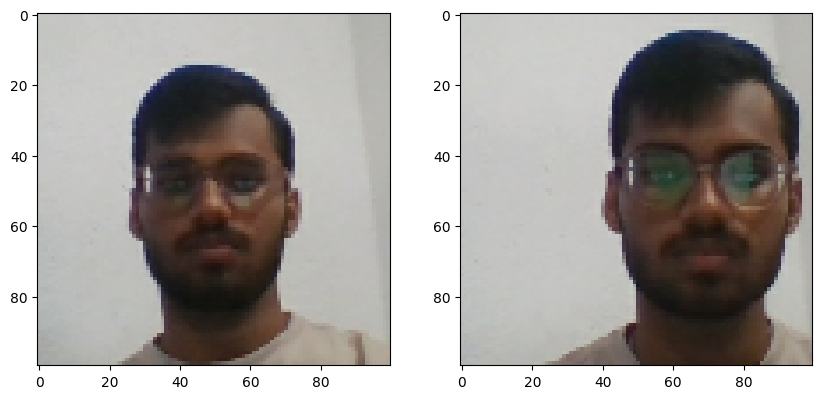

In [53]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [54]:
siamese_model.save('siamesemodelv2.h5')

In [55]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [56]:
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[9.9999994e-01],
       [4.2211954e-12],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [57]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)         ┃ Output Shape       ┃    Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ input_img            │ (None, 100, 100,   │          0 │ -                  │
│ (InputLayer)         │ 3)                 │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ validation_img       │ (None, 100, 100,   │          0 │ -                  │
│ (InputLayer)         │ 3)                 │            │                    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ embedding            │ (None, 4096)       │ 38,960,448 │ input_img[0][0],   │
│ (Functional)         │                    │            │ validation_img[0]… │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ l1_dist (L1Dist)     │ (None, 4096)       │          0 │ embedding[0][0],   │
│                      │                    │            │ embedding[1][0]    │
├──────────────────────┼────────────────────┼────────────┼────────────────────┤
│ dense_3 (Dense)      │ (None, 1)          │      4,097 │ l1_dist[0][0]      │
└──────────────────────┴────────────────────┴────────────┴────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
os.listdir(os.path.join('application_data', 'verification_images'))

['.ipynb_checkpoints',
 '2b92ddd7-7e88-11f0-b053-34e6ad90073f.jpg',
 '2bd80a3e-7e88-11f0-abef-34e6ad90073f.jpg',
 '2be10aab-7e88-11f0-85a6-34e6ad90073f.jpg',
 '2be7a50b-7e88-11f0-9b64-34e6ad90073f.jpg',
 '2bf08213-7e88-11f0-9d26-34e6ad90073f.jpg',
 '2bf827d9-7e88-11f0-af92-34e6ad90073f.jpg',
 '3aac3560-7e88-11f0-bb9d-34e6ad90073f.jpg',
 '3ab4e628-7e88-11f0-ac9b-34e6ad90073f.jpg',
 '3abcb53e-7e88-11f0-88e8-34e6ad90073f.jpg',
 '3ac43b0c-7e88-11f0-a3f9-34e6ad90073f.jpg',
 '3aca5be5-7e88-11f0-bcbc-34e6ad90073f.jpg',
 '3ad383c6-7e88-11f0-a8cd-34e6ad90073f.jpg',
 '3ade5950-7e88-11f0-90a1-34e6ad90073f.jpg',
 '3ae5ad38-7e88-11f0-91ce-34e6ad90073f.jpg',
 '3ae9660c-7e88-11f0-97df-34e6ad90073f.jpg',
 '3aeedb63-7e88-11f0-a0c6-34e6ad90073f.jpg']

In [59]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [60]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\.ipynb_checkpoints
application_data\verification_images\2b92ddd7-7e88-11f0-b053-34e6ad90073f.jpg
application_data\verification_images\2bd80a3e-7e88-11f0-abef-34e6ad90073f.jpg
application_data\verification_images\2be10aab-7e88-11f0-85a6-34e6ad90073f.jpg
application_data\verification_images\2be7a50b-7e88-11f0-9b64-34e6ad90073f.jpg
application_data\verification_images\2bf08213-7e88-11f0-9d26-34e6ad90073f.jpg
application_data\verification_images\2bf827d9-7e88-11f0-af92-34e6ad90073f.jpg
application_data\verification_images\3aac3560-7e88-11f0-bb9d-34e6ad90073f.jpg
application_data\verification_images\3ab4e628-7e88-11f0-ac9b-34e6ad90073f.jpg
application_data\verification_images\3abcb53e-7e88-11f0-88e8-34e6ad90073f.jpg
application_data\verification_images\3ac43b0c-7e88-11f0-a3f9-34e6ad90073f.jpg
application_data\verification_images\3aca5be5-7e88-11f0-bcbc-34e6ad90073f.jpg
application_data\verification_images\3ad383c6-7e88-11f0-a8cd-34e6ad90073f.jpg
applicat

In [61]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    verification_dir = os.path.join('application_data', 'verification_images')

    for image in os.listdir(verification_dir):
        # Skip non-image files (like .ipynb_checkpoints)
        if image.startswith('.') or not image.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join(verification_dir, image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediction is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    total = len([img for img in os.listdir(verification_dir) if img.lower().endswith(('.jpg','.jpeg','.png'))])
    verification = detection / total
    verified = verification > verification_threshold
    
    return results, verified

In [67]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━

In [63]:
np.sum(np.squeeze(results) > 0.9)

0

In [64]:
results

[array([[2.7955429e-12]], dtype=float32),
 array([[1.0660227e-11]], dtype=float32),
 array([[1.7392121e-12]], dtype=float32),
 array([[8.612224e-12]], dtype=float32),
 array([[3.680669e-12]], dtype=float32),
 array([[4.223181e-10]], dtype=float32),
 array([[0.09853857]], dtype=float32),
 array([[0.01002834]], dtype=float32),
 array([[0.22058517]], dtype=float32),
 array([[0.13234907]], dtype=float32),
 array([[0.26404727]], dtype=float32),
 array([[0.36096102]], dtype=float32),
 array([[0.8939477]], dtype=float32),
 array([[0.82691026]], dtype=float32),
 array([[0.82691026]], dtype=float32),
 array([[0.8737945]], dtype=float32)]